In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/AI RESIDENCY/P4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import torchvision
#from torchvision import datasets
#from torchvision import transforms

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import *
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import random 

import warnings
warnings.filterwarnings("ignore")

In [ ]:
## !pip install split-folders
## import splitfolders
## splitfolders.ratio('training', output='drive/My Drive/Colab Notebooks/AI RESIDENCY/P4', ratio=(.8, 0.2)) 

In [3]:
## Data transformation
train_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor()])

valid_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.CenterCrop(1080),
    transforms.Resize(224),
    transforms.ToTensor()])

In [4]:
## Load the data
data_dir = "/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/"

d_train = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                               transform = train_transform)

d_val = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                               transform = valid_transform)

d_test = datasets.ImageFolder(os.path.join(data_dir, 'testing'),
                              transform = test_transform)



## DataLoaders
dl_train = DataLoader(dataset=d_train,
                batch_size=16,
                shuffle=True, 
                drop_last=False)

dl_valid = DataLoader(dataset=d_val,
                      batch_size=1,
                      shuffle=True)

dl_test = DataLoader(dataset=d_test)

In [ ]:
print('Training dataset:')
print('-------------------')
print(f"Classes: {d_train.classes}")
print(f"Class count: {d_train.targets.count(0)}, {d_train.targets.count(1)}")
print(f"Samples:",len(d_train))
print()

print('Validation dataset:')
print('-------------------')
print(f"Classes: {d_val.classes}")
print(f"Class count: {d_val.targets.count(0)}, {d_val.targets.count(1)}")
print(f"Samples:",len(d_val))

print()
print('Test dataset:')
print('------------------')
print(f"Classes: {d_test.classes}")
print(f"Class count: {d_test.targets.count(0)}, {d_test.targets.count(1)}")
print(f"Samples:",len(d_test))

Training dataset:
-------------------
Classes: ['flip', 'notflip']
Class count: 929, 984
Samples: 1913

Validation dataset:
-------------------
Classes: ['flip', 'notflip']
Class count: 233, 246
Samples: 479

Test dataset:
------------------
Classes: ['flip', 'notflip']
Class count: 243, 307
Samples: 550


In [ ]:
inputs, classes = next(iter(dl_train))

In [ ]:
print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')

Batch size: 16
Number of color channels: 3
Image size: 224 x 224


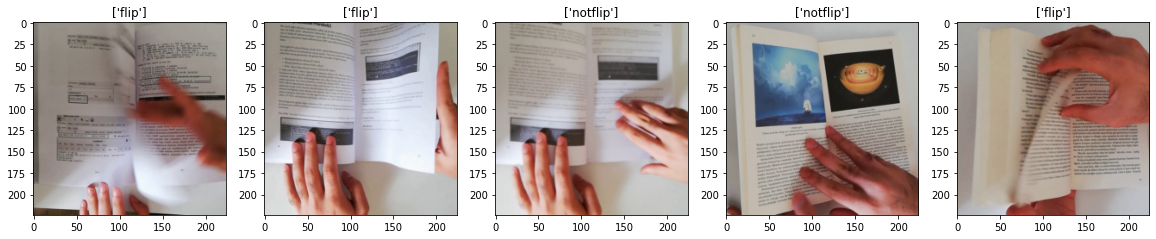

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(inputs[i].permute(1, 2, 0))
    plt.title([d_train.classes[classes[i]]])

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            ## block 1
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=(3, 3)),  ## Convo layer

            nn.ReLU(),                      ## ReLU activation function
            nn.MaxPool2d((2, 2)),           ## Pooling layer
            nn.Dropout(p=.1),               ## Dropout layer

            ## block 2
            nn.Conv2d(64, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(p=.1),
            ## block 3
            nn.Conv2d(32, 16, (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=.1),
             
            nn.Flatten(),
            nn.Linear(10816, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,1))

    def forward(self, x):
        out = torch.sigmoid(self.main(x)) ## sigmoid as we will use the BCELoss loss function
        return out

In [6]:
model = Net()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
         MaxPool2d-3         [-1, 64, 111, 111]               0
           Dropout-4         [-1, 64, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]          18,464
              ReLU-6         [-1, 32, 109, 109]               0
         MaxPool2d-7           [-1, 32, 54, 54]               0
           Dropout-8           [-1, 32, 54, 54]               0
            Conv2d-9           [-1, 16, 53, 53]           2,064
             ReLU-10           [-1, 16, 53, 53]               0
        MaxPool2d-11           [-1, 16, 26, 26]               0
          Dropout-12           [-1, 16, 26, 26]               0
          Flatten-13                [-1, 10816]               0
           Linear-14                 [-

In [7]:
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optim_adam = optim.Adam(model.parameters(), lr=0.001)

In [5]:
## Ref: https://github.com/Bjarten/early-stopping-pytorch
from pytorchtools import EarlyStopping

In [ ]:
def train_model(model, criterion, optimizer, trainloader, valloader, epochs=5, patience=2, verbose=True):
    
    train_loss, train_accuracy = [], []
    val_loss = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        val_batch_loss = 0
        

        # Training
        model.train()
        for X, y in trainloader:
            ## reset the gradient
            optimizer.zero_grad()
            ## forward pass
            y_hat = model(X).flatten()
            ## calculate the loss
            loss = criterion(y_hat, y.type(torch.float32))
            ## backpropagation
            loss.backward()
            ## update the weights
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (torch.round(y_hat) == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(trainloader))
        train_accuracy.append(train_batch_acc / len(trainloader))
        
        
        # Validation
        model.eval()
        for data, target in valloader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data).flatten()
            # calculate the loss
            loss = criterion(output, target.type(torch.float32))
            val_batch_loss += loss.item()

        ## record validation loss
        val_loss.append(val_batch_loss / len(valloader))
        

        ## Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Validation Loss: {val_loss[-1]:.3f}")
            
        
        ## early_stopping needs the validation loss to check if it has decresed, 
        ## and if it has, it will make a checkpoint of the current model
        val_loss_arr = np.average(val_loss)
        early_stopping(val_loss_arr, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

       
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "val_loss": val_loss}
   
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return results, train_loss, train_accuracy, val_loss

In [ ]:
# results, train_loss, train_accuracy, val_loss = train_model(model, criterion, optim_adam, dl_train, dl_valid, epochs=20)

Epoch 1: Train Loss: 0.638 Train Accuracy: 0.65 Validation Loss: 0.500
Validation loss decreased (inf --> 0.500121).  Saving model ...
Epoch 2: Train Loss: 0.290 Train Accuracy: 0.89 Validation Loss: 0.303
Validation loss decreased (0.500121 --> 0.401658).  Saving model ...
Epoch 3: Train Loss: 0.192 Train Accuracy: 0.93 Validation Loss: 0.141
Validation loss decreased (0.401658 --> 0.314904).  Saving model ...
Epoch 4: Train Loss: 0.095 Train Accuracy: 0.97 Validation Loss: 0.127
Validation loss decreased (0.314904 --> 0.267998).  Saving model ...
Epoch 5: Train Loss: 0.088 Train Accuracy: 0.97 Validation Loss: 0.109
Validation loss decreased (0.267998 --> 0.236195).  Saving model ...
Epoch 6: Train Loss: 0.054 Train Accuracy: 0.98 Validation Loss: 0.312
EarlyStopping counter: 1 out of 2
Epoch 7: Train Loss: 0.046 Train Accuracy: 0.99 Validation Loss: 0.113
Validation loss decreased (0.236195 --> 0.229351).  Saving model ...
Epoch 8: Train Loss: 0.044 Train Accuracy: 0.98 Validation L

In [ ]:
## save the model
#torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/model20.ckpt")

In [ ]:
## load the model
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/AI RESIDENCY/P4/model20.ckpt"))

<All keys matched successfully>

In [ ]:
def test_model(model, criterion, testloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for X, y in testloader:
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y).sum()
    
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))

In [ ]:
test_model(model, criterion, dl_test)


Test set: Avg. loss: 0.0266, Accuracy: 546/550 (99%)



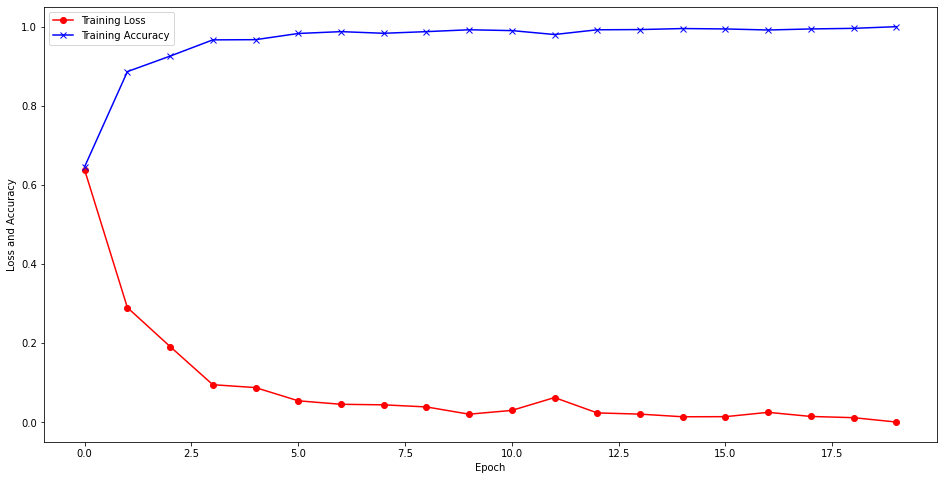

In [ ]:
## save the training loss and accuracy
#np.save('train_loss.npy', np.array(train_loss))
#np.save('train_accuracy.npy', np.array(train_accuracy))

## load the training loss and accuracy
train_loss = np.load('train_loss.npy')
train_accuracy = np.load('train_accuracy.npy')

## plot the training loss and accuracy
plt.figure(figsize=(16,8))
plt.plot(train_loss,color="r",marker="o")
plt.plot(train_accuracy, color='b', marker='x')

plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend(["Training Loss", "Training Accuracy"])
plt.show()

In [ ]:
from sklearn.metrics import classification_report

dl_test_ = DataLoader(dataset=d_test,
                      batch_size=1)

def test_model_batch_size1(model, criterion, testloader):
  model.eval()
  test_loss, correct = 0, 0
  pred_list, true_list = [], []

  with torch.no_grad():
    for X, y in testloader:
      out = model(X).flatten()
      test_loss += criterion(out, y.type(torch.float32))
      correct += torch.round(out).eq(y.type(torch.float32)).sum()
      pred_list.append(torch.round(out))
      true_list.append(y.type(torch.float32))
      
    test_loss /= len(testloader)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader),
            100. * correct / len(testloader)))
    
  return pred_list, true_list

In [ ]:
predictions, labels = test_model_batch_size1(model, criterion, dl_test_)


Test set: Avg. loss: 0.0266, Accuracy: 546/550 (99%)



In [ ]:
predictions, labels = test_model_batch_size1(model, criterion, dl_test_)
print(classification_report([i.item() for i in predictions], [i.item() for i in labels]))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       241
         1.0       1.00      0.99      0.99       309

    accuracy                           0.99       550
   macro avg       0.99      0.99      0.99       550
weighted avg       0.99      0.99      0.99       550



RNN
LSTM
GRU

In [ ]:
## get the images in order -- 5 each time

# train_flip_data, train_flip_labels = [], []
# count = 0

# for i in range(185):
#   l_input, l_target = [], []
#   for j in range(5):
#     l_input.append(d_train[count + j][0])
#    # l_target.append(d_train[count + j][1])
#   tensor_l_input = [torch.tensor(x) for x in l_input]
#   count += 5

#   train_flip_data.append(torch.stack(tensor_l_input, dim=0))

#   train_flip_labels.append(0)

In [43]:
 #train_data, train_labels = [], []

In [6]:
## get the images randomly -- 5 each time --  flip or not flip -- not both at the same time

#data_size = 100
def ImageData(df, data_size, train_val_test, flip=True):

  train_data, train_labels = [], []

  if train_val_test == 'train':
    if flip:
      range_left, range_right = 0, 929
    else:
      range_left, range_right = 929, 1913
  elif train_val_test == 'val':
     if flip:
      range_left, range_right = 0, 233
     else:
      range_left, range_right = 233, 479
  else:
    if flip:
      range_left, range_right = 0, 243
    else:
      range_left, range_right = 243, 550



  for i in range(data_size):
    l_input, l_target = [], []    
    random_numbers = random.sample(range(range_left, range_right), 5)

    for j in range(5):
      l_input.append(df[random_numbers[j]][0])

    tensor_l_input = [torch.tensor(x) for x in l_input]

    train_data.append(torch.stack(tensor_l_input, dim=0))
    if flip:
      train_labels.append(0)
    else:
      train_labels.append(1)  

  return train_data, train_labels

In [7]:
train_data_flip, train_labels_flip = ImageData(df = d_train, data_size = 250, train_val_test = 'train', flip = True)
train_data_not_flip, train_labels_not_flip = ImageData(df = d_train, data_size = 250, train_val_test = 'train', flip = False) 

sequence_5flip = list(zip(train_data_flip, train_labels_flip))
sequence_5notflip = list(zip(train_data_not_flip, train_labels_not_flip))

train_data = sequence_5flip + sequence_5notflip

In [8]:
## sequences of k = 1-4 not flip and 5-k flip
## get the images randomly -- 5 each time -- both flip and not flip


def ImageData2(df, data_size, k, train_val_test):

  train_data2, train_labels2 = [], []

  for i in range(data_size):
    l_input, l_target = [], []

    if train_val_test == 'train':
      range_left_flip, range_right_flip = 0, 929
      range_left_not_flip, range_right_not_flip = 929, 1913
    elif train_val_test == 'val':
      range_left_flip, range_right_flip = 0, 233
      range_left_not_flip, range_right_not_flip = 233, 479
    else:
      range_left_flip, range_right_flip = 0, 243
      range_left_not_flip, range_right_not_flip = 243, 550
    
    random_numbers_flip = random.sample(range(range_left_flip, range_right_flip), 5-k)
    random_numbers_not_flip = random.sample(range(range_left_not_flip, range_right_not_flip), k)

    for j in range(5-k):
      l_input.append(df[random_numbers_flip[j]][0])
    for l in range(k):
      l_input.append(df[random_numbers_not_flip[l]][0])

  
    tensor_l_input = [torch.tensor(x) for x in l_input]
    
    train_data2.append(torch.stack(tensor_l_input, dim=0))

    train_labels2.append(0)

  return train_data2, train_labels2

In [9]:
train_data_1notflip, train_labels_1notflip = ImageData2(df = d_train, data_size = 250, k = 1, train_val_test = 'train',)
train_data_2notflip, train_labels_2notflip = ImageData2(df = d_train, data_size = 250, k = 2, train_val_test = 'train',)
train_data_3notflip, train_labels_3notflip = ImageData2(df = d_train, data_size = 250, k = 3, train_val_test = 'train',)
train_data_4notflip, train_labels_4notflip = ImageData2(df = d_train, data_size = 250, k = 4, train_val_test = 'train',)

sequence_1notflip = list(zip(train_data_1notflip, train_labels_1notflip))
sequence_2notflip = list(zip(train_data_2notflip, train_labels_2notflip))
sequence_3notflip = list(zip(train_data_3notflip, train_labels_3notflip))
sequence_4notflip = list(zip(train_data_4notflip, train_labels_4notflip))

In [10]:
train_data = train_data + sequence_1notflip + sequence_2notflip + sequence_3notflip + sequence_4notflip

In [ ]:
for j in [10,110,210,310,410,510]:
#for j in [10]:
  plt.figure(figsize=(20, 10))
  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[j][0][i].permute(1,2,0))
  if train_data[j][1] == 0:
    print('There is at least one image in the sequence being flipped.')
  else:
    print('None of the images in the sequence is being flipped.')
  plt.show()
  print()

In [11]:
val_data_flip, val_labels_flip = ImageData(df = d_val, data_size = 50, train_val_test = 'val', flip = True)
val_data_not_flip, val_labels_not_flip = ImageData(df = d_val, data_size = 50, train_val_test = 'val', flip = False) 

val_sequence_5flip = list(zip(val_data_flip, val_labels_flip))
val_sequence_5notflip = list(zip(val_data_not_flip, val_labels_not_flip))

val_data = val_sequence_5flip + val_sequence_5notflip

val_data_1notflip, val_labels_1notflip = ImageData2(df = d_val, data_size = 50, k = 1, train_val_test = 'val',)
val_data_2notflip, val_labels_2notflip = ImageData2(df = d_val, data_size = 50, k = 2, train_val_test = 'val',)
val_data_3notflip, val_labels_3notflip = ImageData2(df = d_val, data_size = 50, k = 3, train_val_test = 'val',)
val_data_4notflip, val_labels_4notflip = ImageData2(df = d_val, data_size = 50, k = 4, train_val_test = 'val',)

val_sequence_1notflip = list(zip(val_data_1notflip, val_labels_1notflip))
val_sequence_2notflip = list(zip(val_data_2notflip, val_labels_2notflip))
val_sequence_3notflip = list(zip(val_data_3notflip, val_labels_3notflip))
val_sequence_4notflip = list(zip(val_data_4notflip, val_labels_4notflip))

In [12]:
val_data = val_data + val_sequence_1notflip + val_sequence_2notflip + val_sequence_3notflip + val_sequence_4notflip

In [13]:
test_data_flip, test_labels_flip = ImageData(df = d_test, data_size = 50, train_val_test = 'test', flip = True)
test_data_not_flip, test_labels_not_flip = ImageData(df = d_test, data_size = 50, train_val_test = 'test', flip = False) 

test_sequence_5flip = list(zip(test_data_flip, test_labels_flip))
test_sequence_5notflip = list(zip(test_data_not_flip, test_labels_not_flip))

test_data = test_sequence_5flip + test_sequence_5notflip

test_data_1notflip, test_labels_1notflip = ImageData2(df = d_test, data_size = 50, k = 1, train_val_test = 'test',)
test_data_2notflip, test_labels_2notflip = ImageData2(df = d_test, data_size = 50, k = 2, train_val_test = 'test',)
test_data_3notflip, test_labels_3notflip = ImageData2(df = d_test, data_size = 50, k = 3, train_val_test = 'test',)
test_data_4notflip, test_labels_4notflip = ImageData2(df = d_test, data_size = 50, k = 4, train_val_test = 'test',)

test_sequence_1notflip = list(zip(test_data_1notflip, test_labels_1notflip))
test_sequence_2notflip = list(zip(test_data_2notflip, test_labels_2notflip))
test_sequence_3notflip = list(zip(test_data_3notflip, test_labels_3notflip))
test_sequence_4notflip = list(zip(test_data_4notflip, test_labels_4notflip))

In [14]:
test_data = test_data + test_sequence_1notflip + test_sequence_2notflip + test_sequence_3notflip + test_sequence_4notflip

In [15]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

1500
300
300


In [17]:
1500/16

93.75

In [18]:
seq_train_loader = DataLoader(dataset=train_data,
                              batch_size=16,
                              shuffle=True, 
                              drop_last=False)

In [19]:
seq_val_loader = DataLoader(dataset=val_data,
                              batch_size=1,
                              shuffle=True, 
                              drop_last=False)

In [20]:
seq_test_loader = DataLoader(dataset=test_data,
                              shuffle=True)

In [37]:
print(len(seq_train_loader))
print(len(seq_val_loader))
print(len(seq_test_loader))

94
300
300


In [21]:
inp = next(iter(seq_train_loader))

In [22]:
inp[0].shape

torch.Size([16, 5, 3, 224, 224])

In [23]:
type(inp[0])

torch.Tensor

In [25]:
inp[0].view(16,5,-1).shape

torch.Size([16, 5, 150528])

In [26]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

This model expects the input x to be a tensor of shape (batch_size, seq_length, input_size), where seq_length is the number of images in the sequence and input_size is the size of each image. The model processes the input sequence using an LSTM layer, and the final hidden state is passed through a fully-connected layer to produce the output.

You can then create an instance of this model and pass a sequence of images to it as follows:

In [28]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Set hyperparameters
input_size = 3*224*224  # size of each image (3 for RGB images)
hidden_size = 64  # number of units in the LSTM hidden state
num_layers = 1  # number of LSTM layers
num_classes = 2  # number of output classes
batch_size = 16  # batch size
num_epochs = 5  # number of epochs
seq_length = 5  # number of images in the sequence

cpu


In [29]:
# Create model instance
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)

# Pass a sequence of images to the model
#output = model(inp[0].view(8,5,-1))

In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
## Ref: https://github.com/Bjarten/early-stopping-pytorch
#from pytorchtools import EarlyStopping

In [ ]:
# Train the model
# initialize the early_stopping object
#early_stopping = EarlyStopping(patience=2, verbose=True)
val_loss = []
for epoch in range(num_epochs):

    val_batch_loss = 0
    # Training
    model.train()

    for i, (images, labels) in enumerate(seq_train_loader):
        # Reshape images to (batch_size, sequence_length, input_size)
        images = images.view(-1, seq_length, input_size).to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(seq_train_loader)}], Loss: {loss.item():.4f}')

  
    # Validation
    model.eval()

    correct_val = 0
    for images, labels in seq_val_loader:
        # Reshape images to (batch_size, sequence_length, input_size)
        images = images.view(-1, seq_length, input_size).to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.to(device))
        val_batch_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct_val += (predicted == labels).sum().item()

    ## record validation loss
    val_loss.append(val_batch_loss / len(seq_val_loader))

    ## early_stopping needs the validation loss to check if it has decresed, 
    ## and if it has, it will make a checkpoint of the current model
    #val_loss_arr = np.average(val_loss)
    #early_stopping(val_loss_arr, model)
    
    
    #if early_stopping.early_stop:
     #   print("Early stopping")
      #  break

 # load the last checkpoint with the best model
#model.load_state_dict(torch.load('checkpoint.pt'))
        

In [43]:
correct_val

250

In [44]:
(len(seq_val_loader))

300

In [45]:
print(correct_val/(len(seq_val_loader)))

0.8333333333333334


In [40]:
val_loss

[0.45062941561142605,
 0.45056331157684326,
 0.4508598918716113,
 0.4522910912831624,
 0.45082758863766986]

In [46]:
## Test the model on the test data
model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
  for images, labels in seq_test_loader:
          # Reshape images to (batch_size, sequence_length, input_size)
          images = images.view(-1, seq_length, input_size).to(device)
          
          # Forward pass
          out = model(images)
          test_loss += criterion(out, labels.to(device))
          _, pred = torch.max(out.data, 1)
          correct += (pred == labels).sum().item()

  test_loss /= len(seq_test_loader)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(seq_test_loader),
          100. * correct / len(seq_test_loader)))


Test set: Avg. loss: 0.4536, Accuracy: 250/300 (83%)

